# Diffusion MNIST - Modèle Multi-Classes

Ce notebook implémente un modèle de diffusion capable de générer n'importe quel chiffre MNIST (0-9) en fonction d'une classe spécifiée. Le modèle apprend à générer toutes les classes simultanément.

Pour une approche focalisée sur une seule classe (chiffre 6), voir le notebook `MNIST_SingleClass_Diffusion.ipynb`.

In [16]:
import torch
import torch.nn as nn
import numpy as np
import math
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def sinusoidal_time_embedding(timesteps, dim):
    """
    timesteps: (B,)
    dim: embedding dimension
    returns: (B, dim)
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(0, half, dtype=torch.float32) / half
    ).to(timesteps.device)

    args = timesteps[:, None] * freqs[None]
    return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)


In [3]:
class Double_Conv(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.ReLU(inplace=True)

        self.time_mlp = nn.Linear(time_emb_dim, out_ch)


    def forward(self, x, t_emb=None):
        x = self.act(self.conv1(x))

        if t_emb is not None:
            t_added = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
            x = x + t_added

        x = self.act(self.conv2(x))
        return x


In [4]:
class UNet(nn.Module):
    def __init__(self, num_ch, time_emb_dim=256):
        super().__init__()

        self.time_emb_dim = time_emb_dim

        # MLP for timestep embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.ReLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim),
        )

        # Contracting path with time embedding
        self.down_convolution_1 = Double_Conv(num_ch, 64, time_emb_dim)
        self.down_convolution_2 = Double_Conv(64, 128, time_emb_dim)
        self.down_convolution_3 = Double_Conv(128, 256, time_emb_dim)
        self.down_convolution_4 = Double_Conv(256, 512, time_emb_dim)
        self.down_convolution_5 = Double_Conv(512, 1024, time_emb_dim)

        self.max_pool2d = nn.MaxPool2d(2, 2)

        # Expanding path
        self.up_transpose_1 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.up_convolution_1 = Double_Conv(1024, 512, time_emb_dim)

        self.up_transpose_2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.up_convolution_2 = Double_Conv(512, 256, time_emb_dim)

        self.up_transpose_3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up_convolution_3 = Double_Conv(256, 128, time_emb_dim)

        self.up_transpose_4 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up_convolution_4 = Double_Conv(128, 64, time_emb_dim)

        self.out = nn.Conv2d(64, num_ch, 1)

    def forward(self, x, t):
        # ---- time embedding ----
        t_emb = sinusoidal_time_embedding(t, self.time_emb_dim)
        t_emb = self.time_mlp(t_emb)

        # ---- UNet ----
        down_1 = self.down_convolution_1(x, t_emb)
        down_2 = self.max_pool2d(down_1)

        down_3 = self.down_convolution_2(down_2, t_emb)
        down_4 = self.max_pool2d(down_3)

        down_5 = self.down_convolution_3(down_4, t_emb)
        down_6 = self.max_pool2d(down_5)

        down_7 = self.down_convolution_4(down_6, t_emb)
        down_8 = self.max_pool2d(down_7)

        down_9 = self.down_convolution_5(down_8, t_emb)
        # (NO pooling)

        # ---- upward ----
        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1), t_emb)

        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1), t_emb)

        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1), t_emb)

        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1), t_emb)

        return self.out(x)


In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import MNIST

batch_size = 64

transform = T.Compose([
    T.Resize((16, 16)),
    T.ToTensor(),
])

train_ds = MNIST(root='data', train=True, download=True, transform=transform)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

images, labels = next(iter(train_dl))
print(images.shape)
print(labels.shape)
print(len(train_dl))

torch.Size([64, 1, 16, 16])
torch.Size([64])
938


Paramètres utilisés: T=50, β_min=0.0001, β_max=0.2000


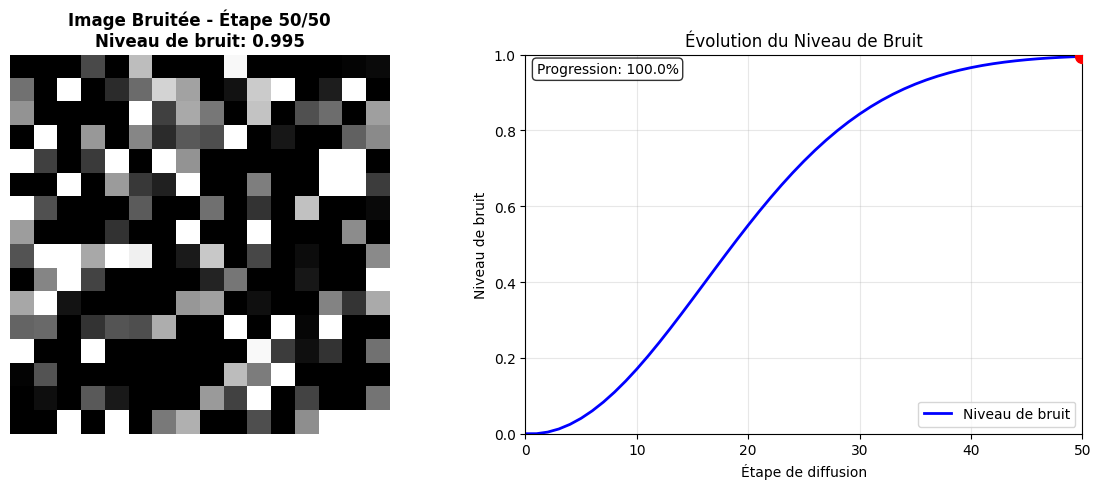

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import numpy as np

def create_noising_gif():
    """Crée un GIF montrant le processus de bruitage d'une image MNIST"""
    # Paramètres de diffusion pour la démonstration
    T = 50
    beta_list_demo = torch.linspace(0.0001, 0.2, steps=T).to(device)
    sigma_list_demo = 1 - beta_list_demo
    sigma_bar_demo = torch.cumprod(sigma_list_demo, dim=0)
    
    # Prendre une image d'exemple du dataset
    sample_image, sample_label = train_ds[0]  # Première image
    sample_image = sample_image.unsqueeze(0).to(device)  # Ajouter batch dimension [1,1,16,16]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    def animate(frame):
        ax1.clear()
        ax2.clear()
        
        t = frame
        
        if t == 0:
            noisy_image = sample_image
            noise_level = 0.0
        else:
            sigma_bar_t = sigma_bar_demo[t-1]
            noise = torch.randn_like(sample_image)
            noisy_image = torch.sqrt(sigma_bar_t) * sample_image + torch.sqrt(1 - sigma_bar_t) * noise
            noise_level = 1 - sigma_bar_t.item()
        
        img_display = noisy_image.squeeze().cpu().numpy()
        
        ax1.imshow(img_display, cmap='gray', vmin=0, vmax=1)
        ax1.set_title(f'Image Bruitée - Étape {t}/{T}\nNiveau de bruit: {noise_level:.3f}', 
                     fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        steps = np.arange(0, T+1)
        noise_levels = np.zeros(T+1)
        noise_levels[1:] = 1 - sigma_bar_demo.cpu().numpy()
        
        ax2.plot(steps[:t+1], noise_levels[:t+1], 'b-', linewidth=2, label='Niveau de bruit')
        ax2.scatter(t, noise_level, color='red', s=100, zorder=5)
        ax2.set_xlim(0, T)
        ax2.set_ylim(0, 1)
        ax2.set_xlabel('Étape de diffusion')
        ax2.set_ylabel('Niveau de bruit')
        ax2.set_title('Évolution du Niveau de Bruit')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        progress = t / T
        ax2.text(0.02, 0.98, f'Progression: {progress:.1%}', 
                transform=ax2.transAxes, fontsize=10, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    anim = animation.FuncAnimation(fig, animate, frames=T+1, interval=300, repeat=True)
    
    print(f"Paramètres utilisés: T={T}, β_min={beta_list_demo[0]:.4f}, β_max={beta_list_demo[-1]:.4f}")
    
    try:
        writer = PillowWriter(fps=4)
        anim.save('mnist_diffusion_noising_process.gif', writer=writer)
    except Exception as e:
        print("Le GIF ne sera pas sauvegardé, mais l'animation est disponible.")
    
    return anim

anim = create_noising_gif()
plt.tight_layout()
plt.show()

In [7]:
T = 50
beta_list= torch.linspace(0.0001, 0.5, steps=T).to(device)
sigma_list = 1 - beta_list

In [ ]:
def train(epochs, dataloader, model, optimizer, loss_fct, T, sigma_list, device):
    """Entrainement sur des images MNIST.
    sigma_list: sequence de taille T contenant les sigma par étape.
    Le modèle est censé prédire le bruit donné l'image bruitée x_t."""
    model.train()

    # Assurer que sigma_list est un tensor qui est sur le bon device (permet d'accélérer l'entrainement)
    if not torch.is_tensor(sigma_list):
        sigma_list = torch.tensor(sigma_list, dtype=torch.float32, device=device)
    else:
        sigma_list = sigma_list.to(device).float()

    # produit cumulatif des sigma
    sigma_bar = torch.cumprod(sigma_list, dim=0)

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for x0, _labels in dataloader:
            x0 = x0.to(device)

            B = x0.size(0)
            # échantillonner des temps t dans {1,..,T} pour chaque échantillon
            t = torch.randint(1, T + 1, (B,), device=device, dtype=torch.long)

            # récupérer sigma_bar pour chaque t échantillonné et redimensionner pour la diffusion
            sigma_bar_t = sigma_bar[t - 1].view(B, 1, 1, 1)

            # échantillonner un bruit gaussien
            noise = torch.randn_like(x0, device=device)

            # construire l'image bruitée x_t
            x_t = torch.sqrt(sigma_bar_t) * x0 + torch.sqrt(1.0 - sigma_bar_t) * noise

            optimizer.zero_grad()

            # le modèle prédit le bruit
            predicted_noise = model(x_t, t)

            loss = loss_fct(noise, predicted_noise)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / (num_batches if num_batches > 0 else 1)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

In [ ]:
epochs = 100
batch_size = 64
learning_rate = 0.001

model = UNet(num_ch=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fct = torch.nn.MSELoss()

train(epochs, train_dl, model, optimizer, loss_fct, T, sigma_list, device)
torch.save(model.state_dict(), 'unet_mnist_50steps_05.pt')

Epoch [1/100], Loss: 0.0784
Epoch [10/100], Loss: 0.0222
Epoch [20/100], Loss: 0.0207
Epoch [30/100], Loss: 0.0197
Epoch [40/100], Loss: 0.0196
Epoch [50/100], Loss: 0.0196
Epoch [60/100], Loss: 0.0193
Epoch [70/100], Loss: 0.0193
Epoch [80/100], Loss: 0.0195
Epoch [90/100], Loss: 0.0195
Epoch [100/100], Loss: 0.0194


In [ ]:
def generate_samples_corrected(model, num_samples, T, device):
    """Génère des échantillons en inversant le processus de diffusion"""
    model.eval()
    
    # Commencer avec du bruit pur
    x_t = torch.randn(num_samples, 1, 16, 16).to(device)
    
    generated_samples = []
    sigma_bar_list = torch.cumprod(sigma_list, dim=0)
    
    with torch.no_grad():
        # Processus de débruitage de T vers 0
        for t in reversed(range(1, T + 1)):
            # Créer un tensor temps pour tous les échantillons
            t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
            
            # Prédire le bruit
            predicted_noise = model(x_t, t_tensor)
            beta_t = beta_list[t - 1]
            sigma_t= sigma_list[t - 1]
            sigma_bar_t = sigma_bar_list[t - 1]
            z= torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
            # Calculer x_{t-1}
            x_t = (1 / torch.sqrt(sigma_t)) * (x_t - (1-sigma_t)/torch.sqrt(1 - sigma_bar_t) * predicted_noise)+  torch.sqrt(beta_t) * z
            # Stocker les échantillons intermédiaires pour visualisation
            generated_samples.append(x_t.cpu().numpy())
    
    return x_t, generated_samples

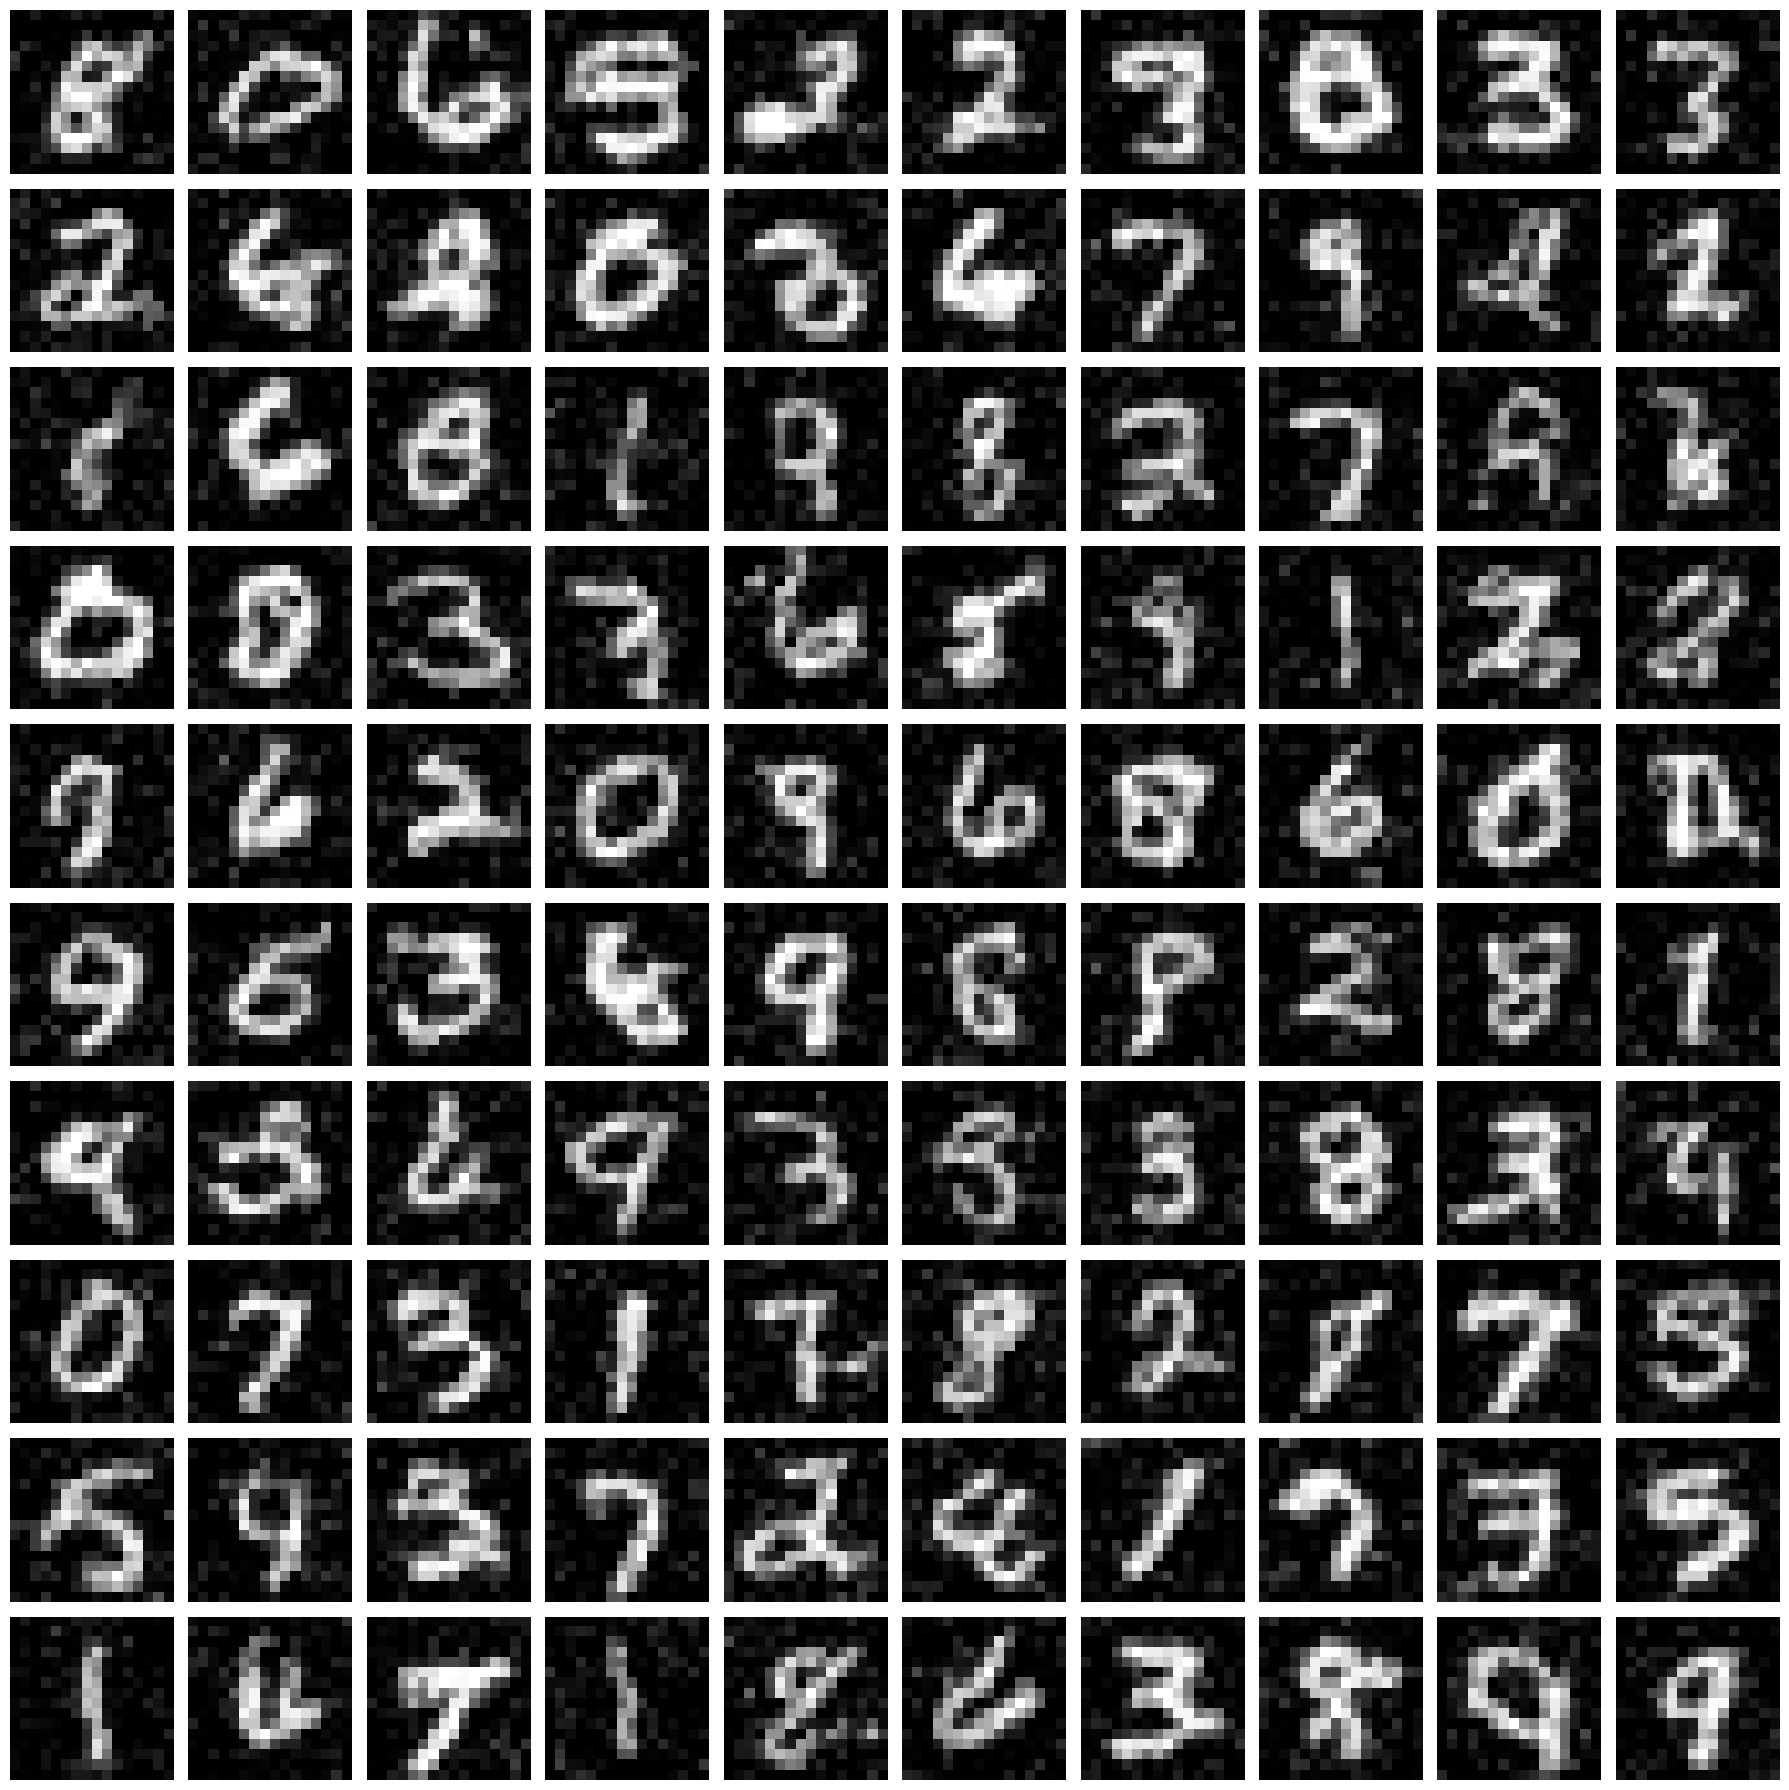

In [ ]:
import matplotlib.pyplot as plt
import math

num_samples = 100
final_x_t, intermediates = generate_samples_corrected(model, num_samples, T, device)

if torch.is_tensor(final_x_t):
    final_imgs = final_x_t.detach().cpu().clamp(0.0, 1.0).squeeze(1).numpy()  # [N,H,W]
else:
    final_imgs = np.array(final_x_t)
N = final_imgs.shape[0]

cols = min(10, N)
rows = math.ceil(N / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*1.8, rows*1.8))
axes = axes.flatten()
for i in range(rows*cols):
    ax = axes[i]
    if i < N:
        ax.imshow(final_imgs[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.tight_layout()
plt.show()

Epoch [1/100], Loss: 0.0749
Epoch [10/100], Loss: 0.0313
Epoch [20/100], Loss: 0.0299
Epoch [30/100], Loss: 0.0294
Epoch [40/100], Loss: 0.0294
Epoch [50/100], Loss: 0.0290
Epoch [60/100], Loss: 0.0287
Epoch [70/100], Loss: 0.0287
Epoch [80/100], Loss: 0.0284
Epoch [90/100], Loss: 0.0286
Epoch [100/100], Loss: 0.0286


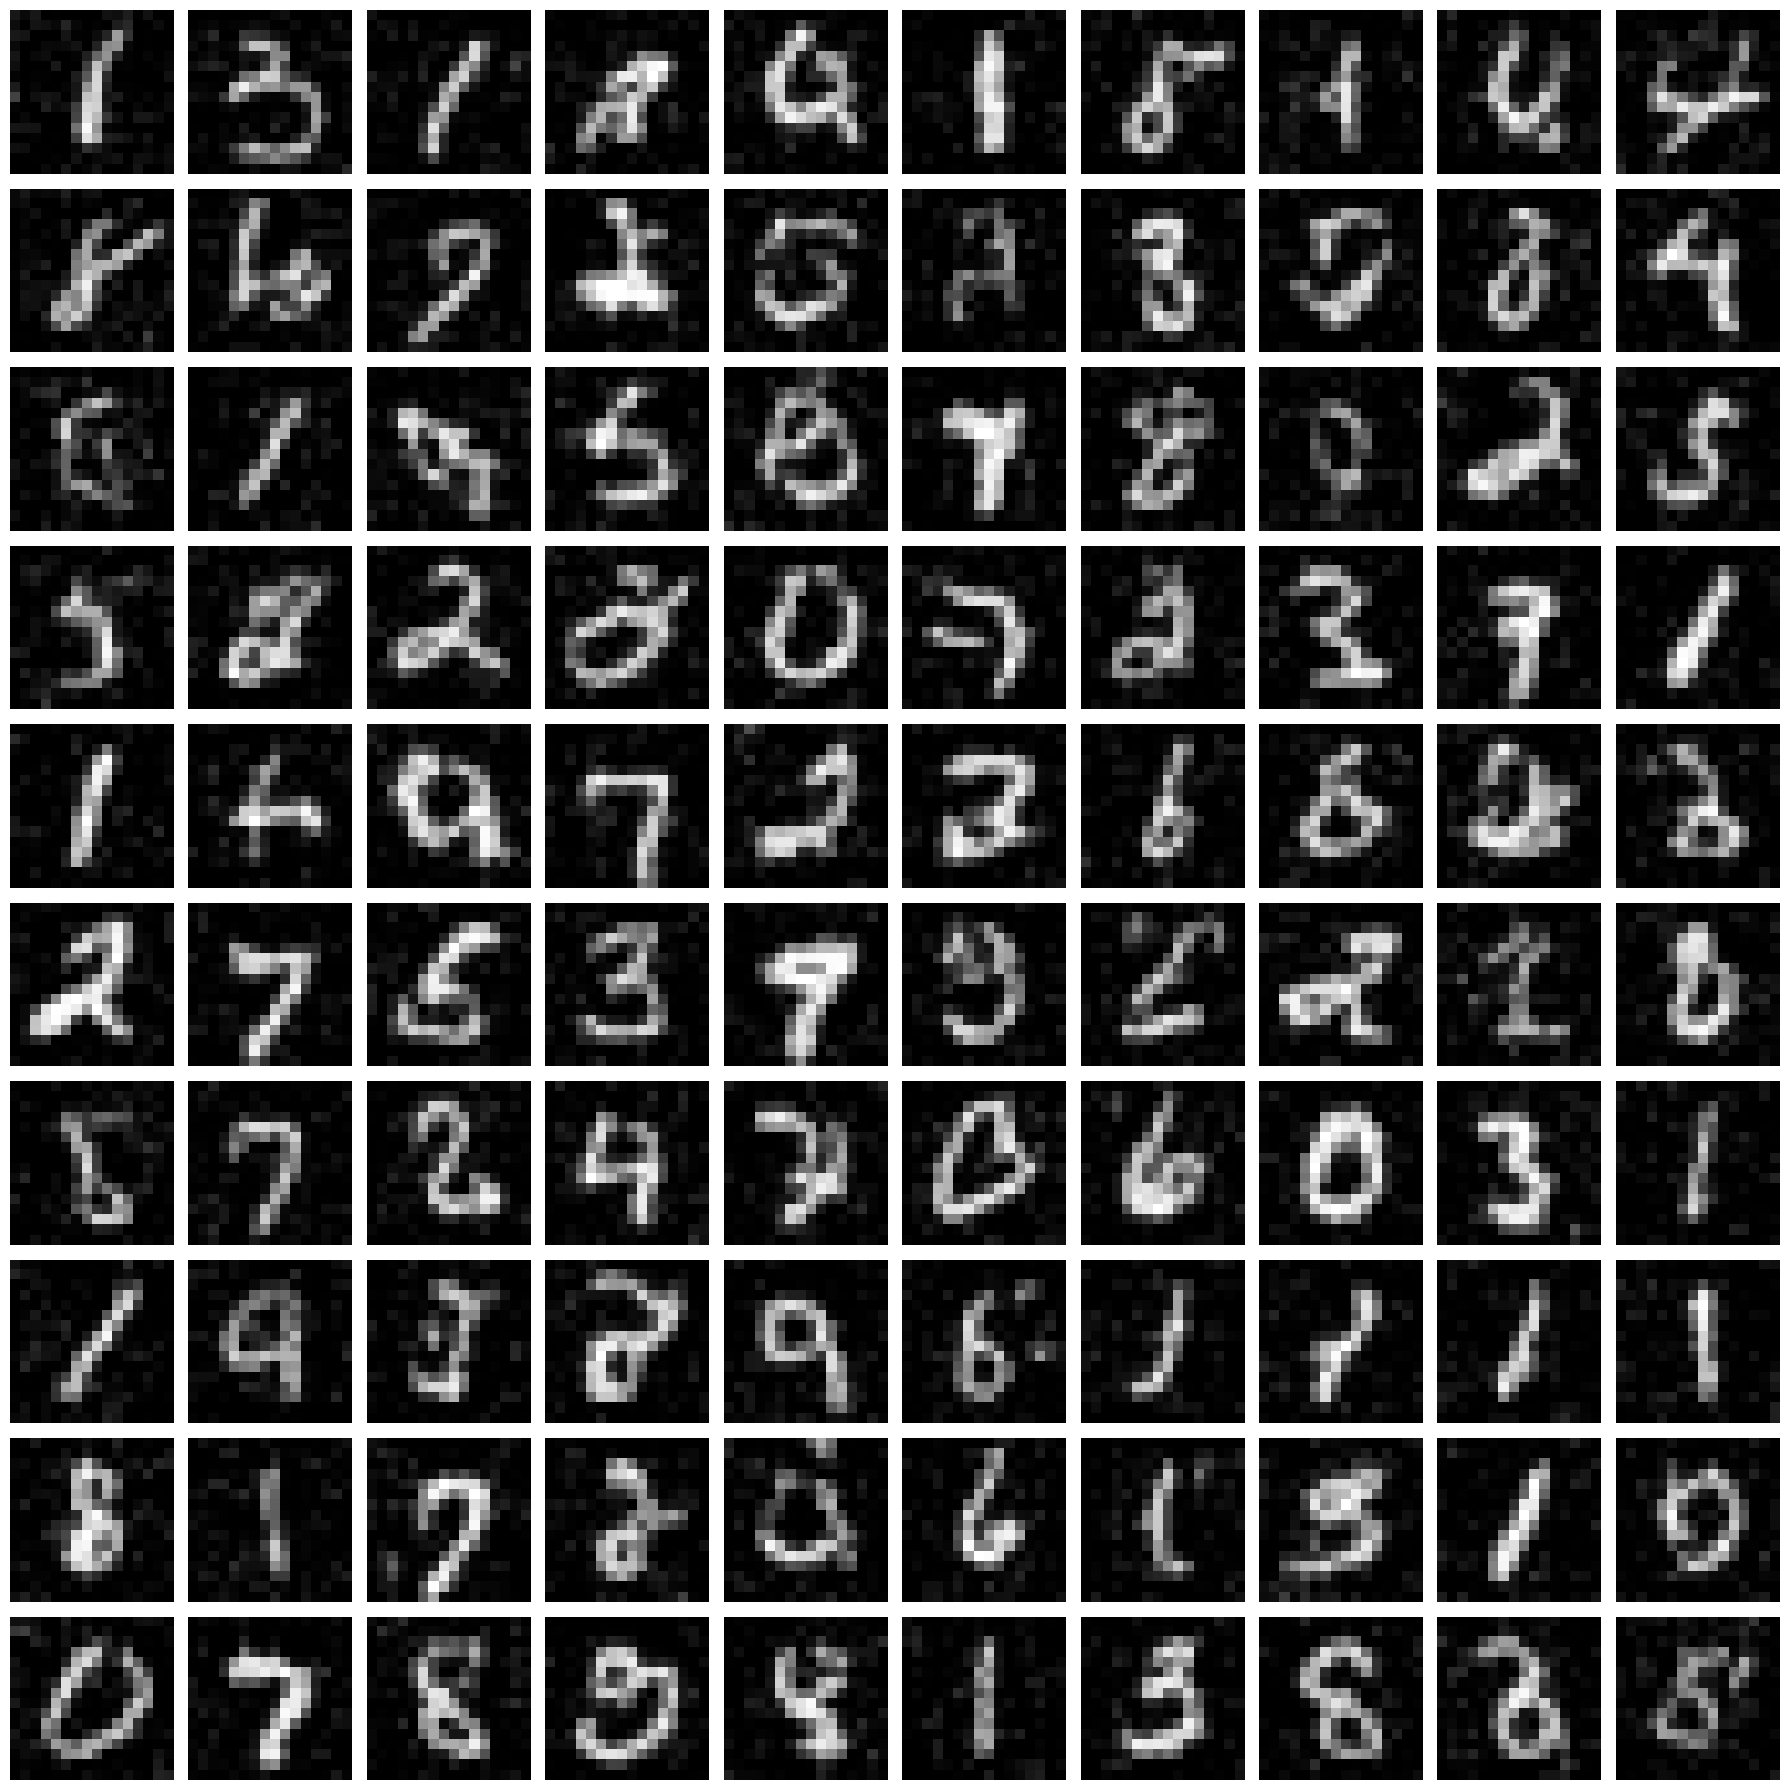

In [ ]:
T = 50
beta_list= torch.linspace(0.0001, 0.2, steps=T).to(device)
sigma_list = 1 - beta_list
model = UNet(num_ch=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fct = torch.nn.MSELoss()
train(epochs, train_dl, model, optimizer, loss_fct, T, sigma_list, device)
torch.save(model.state_dict(), 'unet_mnist_50steps_02.pt')
import matplotlib.pyplot as plt
import math

num_samples = 100
final_x_t, intermediates = generate_samples_corrected(model, num_samples, T, device)

if torch.is_tensor(final_x_t):
    final_imgs = final_x_t.detach().cpu().clamp(0.0, 1.0).squeeze(1).numpy()  # [N,H,W]
else:
    final_imgs = np.array(final_x_t)
N = final_imgs.shape[0]

cols = min(10, N)
rows = math.ceil(N / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*1.8, rows*1.8))
axes = axes.flatten()
for i in range(rows*cols):
    ax = axes[i]
    if i < N:
        ax.imshow(final_imgs[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
if intermediates:
    inter_list = []
    for step in intermediates:
        if torch.is_tensor(step):
            step_np = step.detach().cpu().squeeze(1).numpy()
        else:
            step_np = np.array(step)
            if step_np.ndim == 4:
                step_np = step_np.squeeze(1)
        inter_list.append(step_np)
    inter_np = np.stack(inter_list, axis=0)

    K = N  
    cols = inter_np.shape[0] 
    rows = K
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.2, rows*1.2))
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c] if rows>1 and cols>1 else (axes[c] if rows==1 else axes[r])
            ax.imshow(inter_np[c, r], cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

Epoch [1/100], Loss: 0.0363
Epoch [10/100], Loss: 0.0113
Epoch [20/100], Loss: 0.0105
Epoch [30/100], Loss: 0.0101
Epoch [40/100], Loss: 0.0098
Epoch [50/100], Loss: 0.0097
Epoch [60/100], Loss: 0.0099
Epoch [70/100], Loss: 0.0098
Epoch [80/100], Loss: 0.0096
Epoch [90/100], Loss: 0.0096
Epoch [100/100], Loss: 0.0095


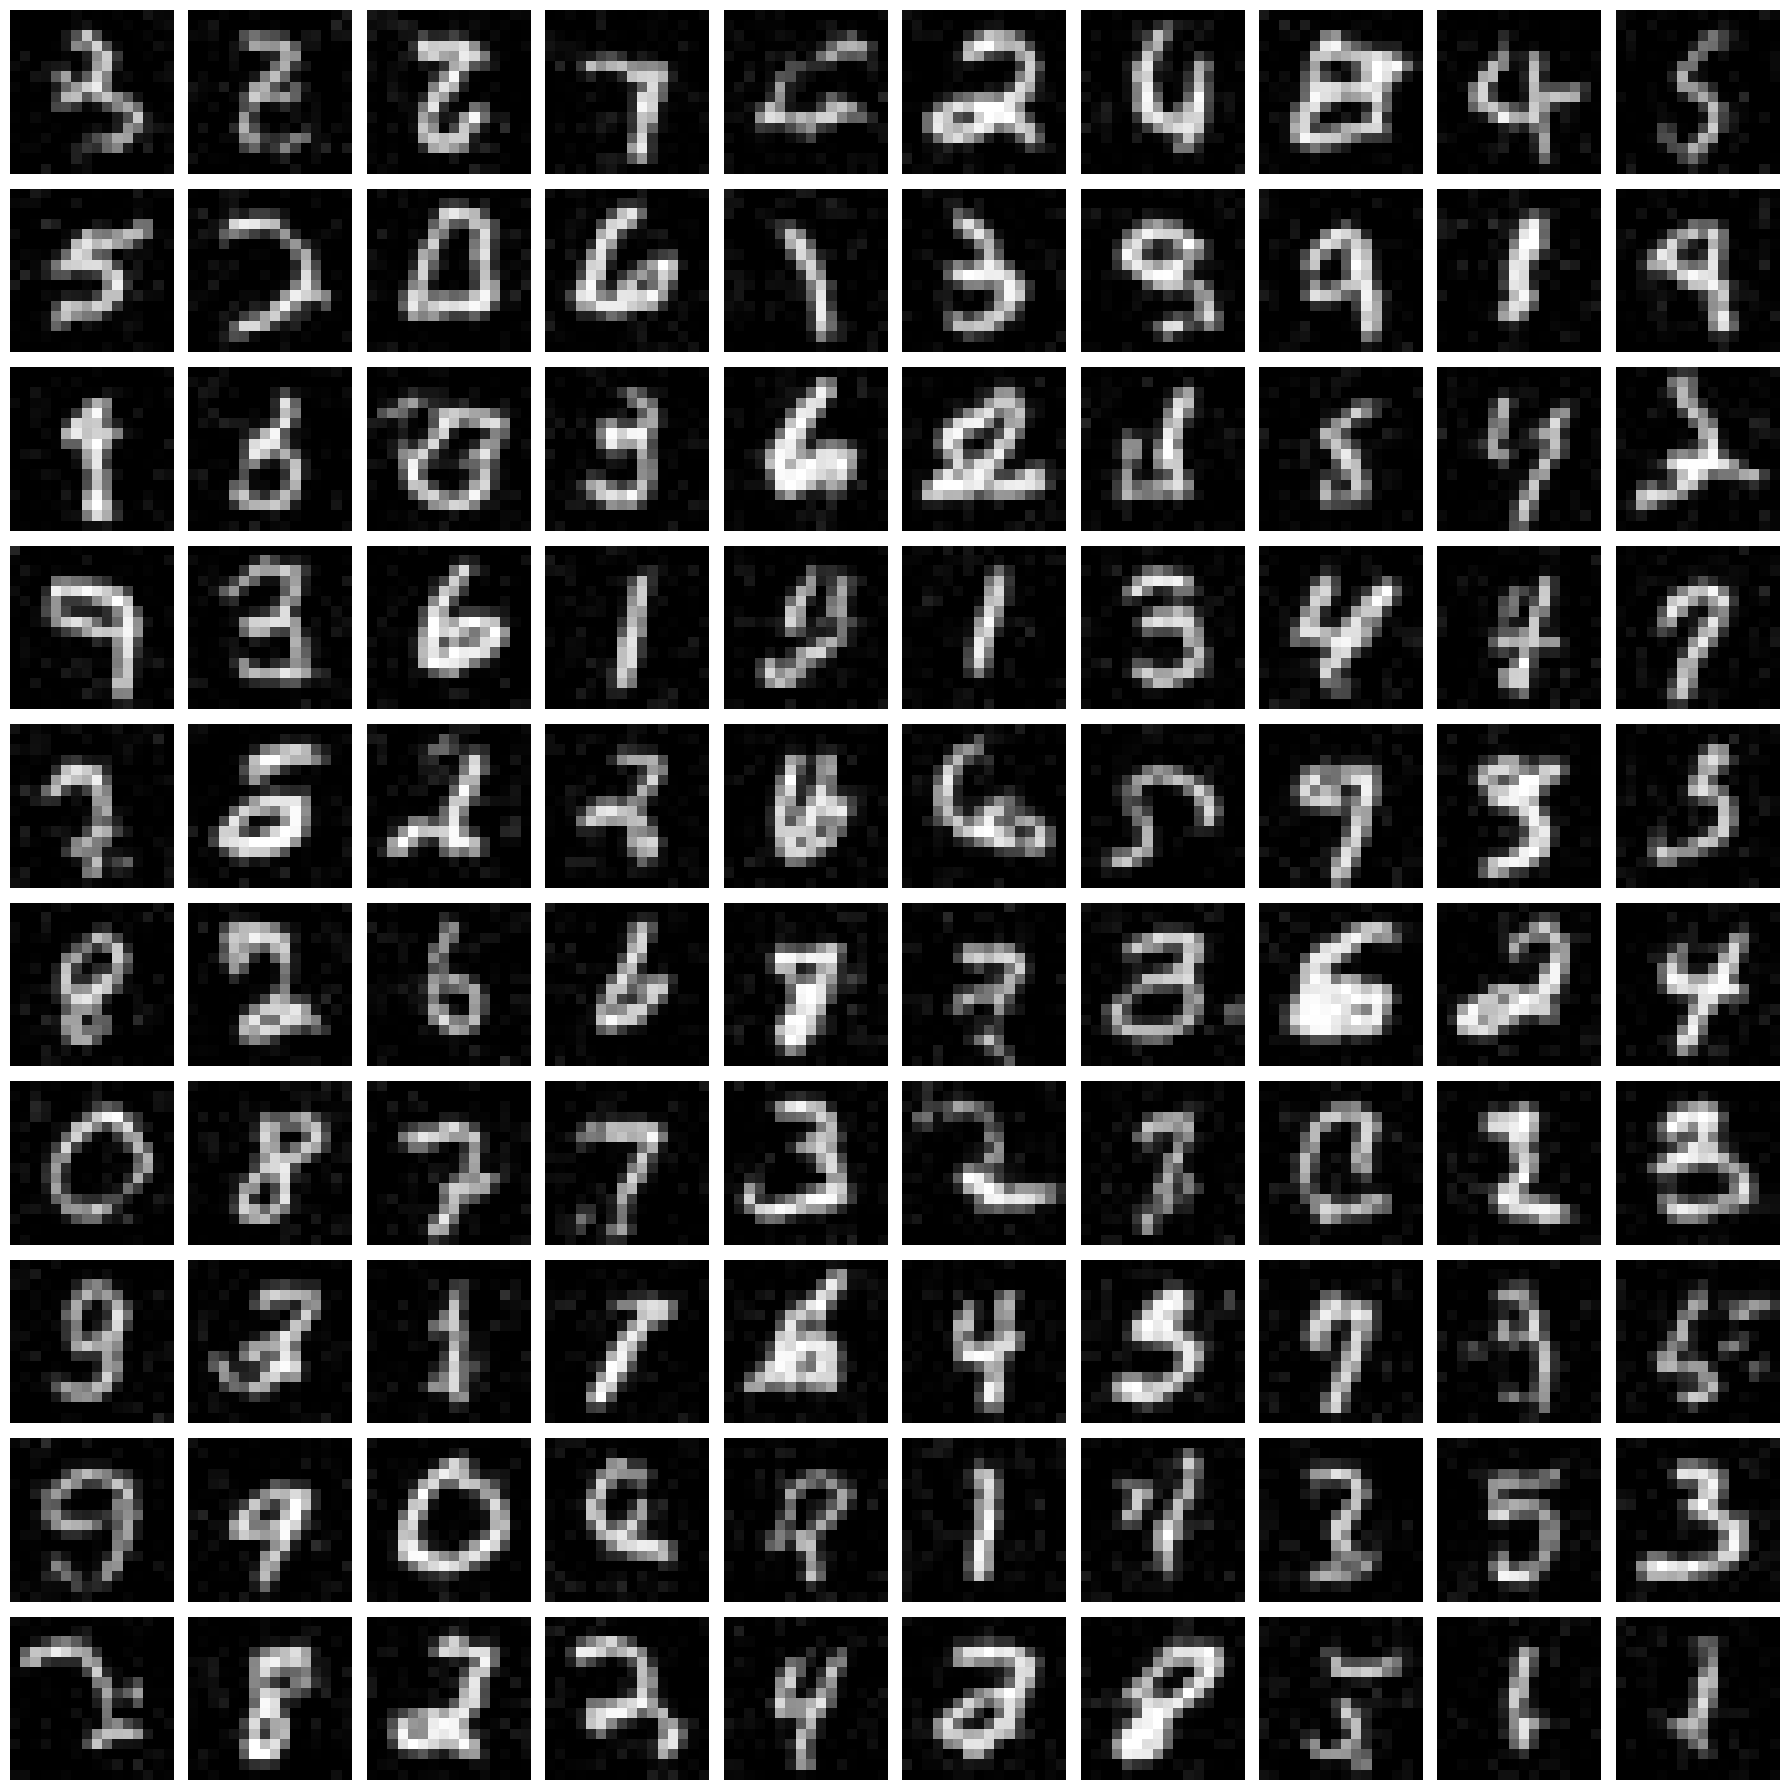

In [ ]:
T = 200
epochs = 100
learning_rate = 0.001
beta_list= torch.linspace(0.0001, 0.5, steps=T).to(device)
sigma_list = 1 - beta_list
model = UNet(num_ch=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fct = torch.nn.MSELoss()
train(epochs, train_dl, model, optimizer, loss_fct, T, sigma_list, device)
torch.save(model.state_dict(), 'unet_mnist_200steps_05.pt')
import matplotlib.pyplot as plt
import math

num_samples = 100
final_x_t, intermediates = generate_samples_corrected(model, num_samples, T, device)

if torch.is_tensor(final_x_t):
    final_imgs = final_x_t.detach().cpu().clamp(0.0, 1.0).squeeze(1).numpy()  # [N,H,W]
else:
    final_imgs = np.array(final_x_t)
N = final_imgs.shape[0]

cols = min(10, N)
rows = math.ceil(N / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*1.8, rows*1.8))
axes = axes.flatten()
for i in range(rows*cols):
    ax = axes[i]
    if i < N:
        ax.imshow(final_imgs[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.tight_layout()
plt.show()